<a href="https://colab.research.google.com/github/tungrix/recommender-system/blob/Joel/SDSC3002_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommending movies: retrieval with distribution strategy

In this tutorial, we're going to train the same retrieval model as we did in the [basic retrieval](basic_retrieval) tutorial, but with distribution strategy.

We're going to:

1. Get our data and split it into a training and test set.
2. Set up two virtual GPUs and TensorFlow MirroredStrategy.
3. Implement a retrieval model using MirroredStrategy.
4. Fit it with MirrorredStrategy and evaluate it.



## Imports


Let's first get our imports out of the way.

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import os
import pprint
import tempfile
import matplotlib.pyplot as plt

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow_recommenders as tfrs

## Set up two virtual GPUs

If you have not added GPU accelerators to your Colab, please disconnect the Colab runtime and do it now. We need the GPU to run the code below:

In [4]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices("GPU")
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

strategy = tf.distribute.MirroredStrategy()

2 Physical GPU, 3 Logical GPUs


## Preparing the dataset

We prepare the dataset in exactly the same way as we do in the [basic retrieval](basic_retrieval) tutorial.

In [5]:
# Ratings data.
ratings_raw = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
movies_raw = tfds.load("movielens/100k-movies", split="train")

for x in ratings_raw.take(1).as_numpy_iterator():
  pprint.pprint(x)

for x in movies_raw.take(1).as_numpy_iterator():
  pprint.pprint(x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incomplete5EKDRW/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incomplete8VC7YN/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In [6]:
for x in ratings_raw.take(1).as_numpy_iterator():
  pprint.pprint(x["movie_genres"])

array([7])


Given the overlapping nature of some of the features in the dataset (see `'bucketized_user_age'`/`'raw_user_age'`, `'user_occupation_label'`/`'user_occupation_text'`), we only decide to take one feature for each category. Then, we convert `'user_occupation_label'`, `'bucketized_user_age'`, `'user_gender'` to string type data, so that we can later create embeddings for said features.

In [7]:
ratings = ratings_raw.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_occupation_label": tf.strings.as_string(x["user_occupation_label"]),
    "bucketized_user_age": tf.strings.as_string(tf.dtypes.cast(x["bucketized_user_age"], tf.int32)),
    "user_gender": tf.strings.as_string(x["user_gender"]),
    "timestamp": x["timestamp"]
})
movies = movies_raw.map(lambda x: x["movie_title"])

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

In [8]:
user_ratings = ratings.batch(1_000_000).map(lambda x: x["user_rating"])
u_ratings = np.concatenate(list(user_ratings))

In [9]:
user_occupations = ratings.batch(1_000_000).map(lambda x: x["user_occupation_label"])
unique_occupations = np.unique(np.concatenate(list(user_occupations)))

In [10]:
user_ages = ratings.batch(1_000_000).map(lambda x: x["bucketized_user_age"])
unique_ages = np.unique(np.concatenate(list(user_ages)))

In [11]:
user_genders = ratings.batch(1_000_000).map(lambda x: x["user_gender"])
unique_genders = np.unique(np.concatenate(list(user_genders)))

In [12]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

To normalize the `'timestamps'` feature we find values for minimum and maximum and split the interval into `n=1000` buckets

In [13]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

## Implementing a model

We implement the user_model, movie_model, metrics and task, then we wrap them in the distribution strategy scope:

In [25]:
embedding_dimension = 32

In [26]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
          vocabulary=unique_user_ids, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.user_occupation = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_occupations, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
        tf.keras.layers.Embedding(len(unique_occupations) + 1, embedding_dimension)
    ])
    
    self.user_age = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_ages, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
        tf.keras.layers.Embedding(len(unique_ages) + 1, embedding_dimension)
    ])

    
    self.user_gender = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
          vocabulary=unique_genders, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
        tf.keras.layers.Embedding(len(unique_genders) + 1, embedding_dimension)
    ])
    
    self.user_rating = tf.keras.layers.Normalization(axis=None)
    self.user_rating.adapt(u_ratings)

    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

    self.normalized_timestamp.adapt(timestamps)



  def call(self, inputs):
#     return self.user_embedding(inputs)
    
#     return tf.concat([
#         self.user_embedding(inputs["user_id"]),
#         self.timestamp_embedding(inputs["timestamp"]),
#         tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
#     ], axis=1)

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.user_occupation(inputs["user_occupation_label"]),
            self.user_age(inputs["bucketized_user_age"]),
            self.user_gender(inputs["user_gender"]),
            tf.reshape(self.user_rating(inputs["user_rating"]), (-1, 1)),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
        ], axis=1)

In [27]:
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)
    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])
    self.title_vectorizer.adapt(movies)

  def call(self, input):
    return tf.concat([
        self.title_embedding(input),
        self.title_text_embedding(input),
    ], axis=1)


In [28]:
with strategy.scope():
    query_model = tf.keras.Sequential([
      UserModel(),
      tf.keras.layers.Dense(32)
    ])
    candidate_model = tf.keras.Sequential([
      MovieModel(),
      tf.keras.layers.Dense(32)
    ])
    task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(candidate_model),
        ),
    )

We can now put it all together into a model.

In [29]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, query_model, candidate_model):
    super().__init__()
    self.query_model = query_model
    self.candidate_model = candidate_model
    self.task = task

  def compute_loss(self, features, training=False):
#     query_embeddings = self.query_model(features["user_id"])
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "user_occupation_label": features["user_occupation_label"],
        "bucketized_user_age": features["bucketized_user_age"],
        "user_gender": features["user_gender"],
        "user_rating": features["user_rating"],
        "timestamp": features["timestamp"]
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(query_embeddings, movie_embeddings)

## Fitting and evaluating

Now we initialize and compile the model within the distribution strategy scope.

In [38]:
with strategy.scope():
  model = MovielensModel(query_model, candidate_model)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

Then we shuffle, batch, and cache the training and evaluation data.

In [20]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Then train the  model:

In [22]:
# this is the base implementation 30 epochs
history_base = model.fit(cached_train, epochs=100)

Epoch 1/100
10/10 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0049 - factorized_top_k/top_5_categorical_accuracy: 0.0158 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.0897 - factorized_top_k/top_100_categorical_accuracy: 0.1545 - loss: 60407.7244 - regularization_loss: 0.0000e+00 - total_loss: 60407.7244
Epoch 2/100
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.0097 - factorized_top_k/top_10_categorical_accuracy: 0.0202 - factorized_top_k/top_50_categorical_accuracy: 0.0977 - factorized_top_k/top_100_categorical_accuracy: 0.1889 - loss: 58941.4077 - regularization_loss: 0.0000e+00 - total_loss: 58941.4077
Epoch 3/100
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 

In [47]:
model.evaluate(
    cached_test, return_dict=True)

5/5 [==============================] - 7s 791ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0148 - factorized_top_k/top_50_categorical_accuracy: 0.1276 - factorized_top_k/top_100_categorical_accuracy: 0.2675 - loss: 28152.9229 - regularization_loss: 0.0000e+00 - total_loss: 28152.9229


{'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_5_categorical_accuracy': 0.005499999970197678,
 'factorized_top_k/top_10_categorical_accuracy': 0.014750000089406967,
 'factorized_top_k/top_50_categorical_accuracy': 0.12764999270439148,
 'factorized_top_k/top_100_categorical_accuracy': 0.267549991607666,
 'loss': 25558.2109375,
 'regularization_loss': 0,
 'total_loss': 25558.2109375}

In [31]:
# this is the model with all features 30 epochs
history_feat = model.fit(cached_train, epochs=30)

Epoch 1/30
10/10 [==============================] - 30s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0093 - factorized_top_k/top_5_categorical_accuracy: 0.0190 - factorized_top_k/top_10_categorical_accuracy: 0.0266 - factorized_top_k/top_50_categorical_accuracy: 0.0627 - factorized_top_k/top_100_categorical_accuracy: 0.0929 - loss: 73034.3633 - regularization_loss: 0.0000e+00 - total_loss: 73034.3633    
Epoch 2/30
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 9.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0061 - factorized_top_k/top_10_categorical_accuracy: 0.0132 - factorized_top_k/top_50_categorical_accuracy: 0.0704 - factorized_top_k/top_100_categorical_accuracy: 0.1364 - loss: 62921.5749 - regularization_loss: 0.0000e+00 - total_loss: 62921.5749
Epoch 3/30
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0019 - factorized_top_k/top_5_categorical_accur

In [32]:
model.evaluate(
    cached_test, return_dict=True)

5/5 [==============================] - 12s 760ms/step - factorized_top_k/top_1_categorical_accuracy: 2.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0054 - factorized_top_k/top_10_categorical_accuracy: 0.0162 - factorized_top_k/top_50_categorical_accuracy: 0.1390 - factorized_top_k/top_100_categorical_accuracy: 0.2942 - loss: 28451.3467 - regularization_loss: 0.0000e+00 - total_loss: 28451.3467


{'factorized_top_k/top_1_categorical_accuracy': 0.00019999999494757503,
 'factorized_top_k/top_5_categorical_accuracy': 0.005350000225007534,
 'factorized_top_k/top_10_categorical_accuracy': 0.016249999403953552,
 'factorized_top_k/top_50_categorical_accuracy': 0.13899999856948853,
 'factorized_top_k/top_100_categorical_accuracy': 0.29420000314712524,
 'loss': 25856.677734375,
 'regularization_loss': 0,
 'total_loss': 25856.677734375}

In [39]:
# this is the final implementation 100 epochs
history_all = model.fit(cached_train, epochs=100)

Epoch 1/100
10/10 [==============================] - 29s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0090 - factorized_top_k/top_5_categorical_accuracy: 0.0335 - factorized_top_k/top_10_categorical_accuracy: 0.0546 - factorized_top_k/top_50_categorical_accuracy: 0.1730 - factorized_top_k/top_100_categorical_accuracy: 0.2856 - loss: 68339.2003 - regularization_loss: 0.0000e+00 - total_loss: 68339.2003
Epoch 2/100
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0201 - factorized_top_k/top_10_categorical_accuracy: 0.0415 - factorized_top_k/top_50_categorical_accuracy: 0.1863 - factorized_top_k/top_100_categorical_accuracy: 0.3241 - loss: 58686.8864 - regularization_loss: 0.0000e+00 - total_loss: 58686.8864
Epoch 3/100
10/10 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 

In [40]:
model.evaluate(
    cached_test, return_dict=True)

5/5 [==============================] - 7s 753ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0059 - factorized_top_k/top_10_categorical_accuracy: 0.0170 - factorized_top_k/top_50_categorical_accuracy: 0.1402 - factorized_top_k/top_100_categorical_accuracy: 0.2887 - loss: 28680.6403 - regularization_loss: 0.0000e+00 - total_loss: 28680.6403


{'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_5_categorical_accuracy': 0.005900000222027302,
 'factorized_top_k/top_10_categorical_accuracy': 0.016950000077486038,
 'factorized_top_k/top_50_categorical_accuracy': 0.14020000398159027,
 'factorized_top_k/top_100_categorical_accuracy': 0.2886500060558319,
 'loss': 26121.015625,
 'regularization_loss': 0,
 'total_loss': 26121.015625}

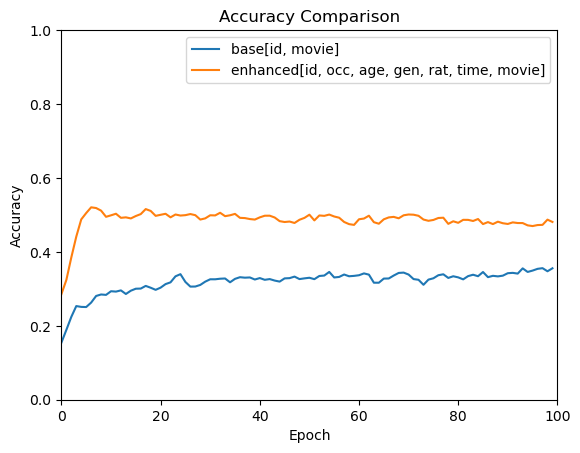

In [41]:
# plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history_base.history["factorized_top_k/top_100_categorical_accuracy"], label='base[id, movie]')
plt.plot(history_all.history["factorized_top_k/top_100_categorical_accuracy"], label='enhanced[id, occ, age, gen, rat, time, movie]')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.legend()
plt.show()